In [5]:
from snowflake.snowpark.session import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark.window import Window
from sklearn import preprocessing # https://github.com/Snowflake-Labs/snowpark-python-demos/tree/main/sp4py_utilities
from snowflake.snowpark.functions import col

import getpass
import pandas as pd
import matplotlib.pyplot as plt


In [358]:
accountname = 'lo67467.ap-southeast-1'

In [359]:
username = getpass.getpass()    # SNOWFLAKE-USERNAME

In [360]:
password = getpass.getpass()    # SNOWFLAKE-PASSWORD

In [361]:
from xgboost import XGBRegressor 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import snowflake.connector

conn = snowflake.connector.connect(
    user=username,
    password=password,
    account=accountname,
    warehouse='COMPUTE_WH',
    #warehouse='HOL_WH',
    #database='FROSTBYTE_TASTY_BYTES',
    #schema='ANALYTICS'
)
#connection
connection_parameters = {
    "account": accountname,
    "user": username,
    "password": password,
    "role": "ACCOUNTADMIN",
    #"database": "FROSTBYTE_TASTY_BYTES",
    "warehouse": 'COMPUTE_WH'
    #"warehouse": "HOL_WH"
}

session = Session.builder.configs(connection_parameters).create()


In [368]:
#X_final_scaled = pd.read_csv('x_final_scaled.csv')

In [363]:
#X_final_scaled

,TRUCK_ID,MONTH,HOUR,DOW,DAY,PUBLIC_HOLIDAY,Profit,LAT,LONG,LOCATION_ID,...,CITY_SEATTLE_ENCODED,CITY_DENVER_ENCODED,CITY_San Mateo_encoded,CITY_New York City_encoded,CITY_BOSTON_ENCODED,REGION_NY_ENCODED,REGION_MA_ENCODED,REGION_CO_ENCODED,REGION_WA_ENCODED,REGION_CA_ENCODED
0,68,7,8,6,10,0,10027.0,40.768807,-73.985856,3007,...,0,0,0,1,0,1,0,0,0,0
1,68,7,9,6,10,0,17477.0,40.768807,-73.985856,3007,...,0,0,0,1,0,1,0,0,0,0
2,68,7,10,6,10,0,13992.0,40.768807,-73.985856,3007,...,0,0,0,1,0,1,0,0,0,0
3,68,7,11,6,10,0,17616.0,40.768807,-73.985856,3007,...,0,0,0,1,0,1,0,0,0,0
4,68,7,12,6,10,0,15415.0,40.768807,-73.985856,3007,...,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540196,17,4,9,3,8,0,5711.0,39.750495,-104.932312,5115,...,0,1,0,0,0,0,0,1,0,0
540197,17,4,10,3,8,0,3741.0,39.750495,-104.932312,5115,...,0,1,0,0,0,0,0,1,0,0
540198,17,4,11,3,8,0,2786.0,39.750495,-104.932312,5115,...,0,1,0,0,0,0,0,1,0,0
540199,17,4,12,3,8,0,4843.0,39.750495,-104.932312,5115,...,0,1,0,0,0,0,0,1,0,0


In [330]:
session.use_schema("ANALYTICS")
X_final_scaled=session.sql('Select * from "Sales_Forecast_Training_Data"').to_pandas()
#X_final_scaled = X_final_scaled.iloc[:, [0,1, 2, 3,4,5,6,7,8,9,10,11,12,28,29,30,31,32,33,34,35,36,37]] 
#X_final_scaled = X_final_scaled.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,20,21,22,24,27,28,29,30,31,32,33,34,35,36,37]] 

In [369]:
#X_final_scaled.drop('LAT', axis=1, inplace=True)
#X_final_scaled.drop('DOW', axis=1, inplace=True)
X_final_scaled.drop('PUBLIC_HOLIDAY', axis=1, inplace=True)
#X_final_scaled.drop('SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE', axis=1, inplace=True)

In [370]:
X_final_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540201 entries, 0 to 540200
Data columns (total 37 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   TRUCK_ID                                  540201 non-null  int64  
 1   MONTH                                     540201 non-null  int64  
 2   HOUR                                      540201 non-null  int64  
 3   DOW                                       540201 non-null  int64  
 4   DAY                                       540201 non-null  int64  
 5   Profit                                    540201 non-null  float64
 6   LAT                                       540201 non-null  float64
 7   LONG                                      540201 non-null  float64
 8   LOCATION_ID                               540201 non-null  int64  
 9   SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE        540201 non-null  float64
 10  SUM_PREV_YEAR_MONTH_

Feature 1: 0.779276
Feature 2: 0.001307
Feature 3: 0.111625
Feature 4: 0.003169
Feature 5: 0.000921
Feature 6: 0.001238
Feature 7: 0.578047
Feature 8: 0.466503
Feature 9: 0.433097
Feature 10: 0.746928
Feature 11: 0.365405
Feature 12: 0.011273
Feature 13: 0.005992
Feature 14: 0.003293
Feature 15: 0.005890
Feature 16: 0.004828
Feature 17: 0.002003
Feature 18: 0.007686
Feature 19: 0.003432
Feature 20: 0.038470
Feature 21: 0.016497
Feature 22: 0.013232
Feature 23: 0.005620
Feature 24: 0.049781
Feature 25: 0.011833
Feature 26: 0.009013
Feature 27: 0.026172
Feature 28: 0.051941
Feature 29: 0.075530
Feature 30: 0.258049
Feature 31: 0.353675
Feature 32: 0.040336
Feature 33: 0.350898
Feature 34: 0.039762
Feature 35: 0.076102
Feature 36: 0.054140
Feature 37: 0.257216


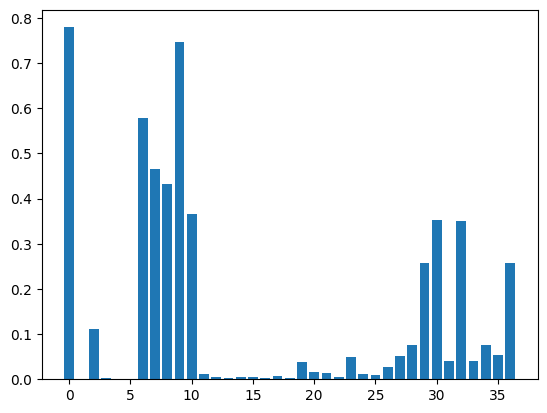

In [238]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt 

# feature selection
def select_features(X_train, y_train, X_test):
    # configure to select a subset of features
    fs = SelectKBest(score_func=mutual_info_regression, k=17)
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i+1, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

<AxesSubplot:ylabel='SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE'>

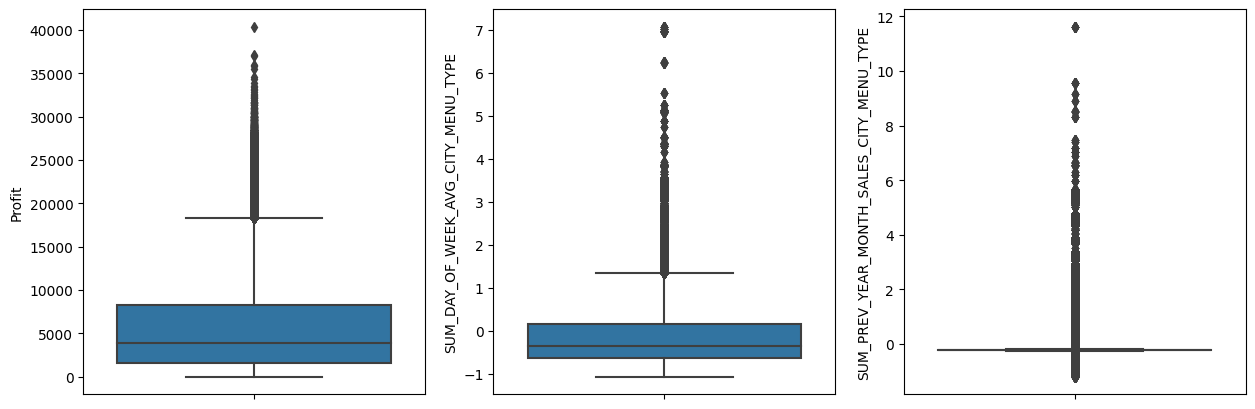

In [283]:
#check for outliers
import numpy as np
import seaborn as sns

fig, axs = plt.subplots(figsize=(15, 5), ncols=3)

sns.boxplot(y='Profit', data=X_final_scaled, ax=axs[0])
sns.boxplot(y='SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE', data=X_final_scaled, ax=axs[1])
sns.boxplot(y='SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE', data=X_final_scaled, ax=axs[2])

In [181]:
#X_final_scaled['SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE'] = X_final_scaled['SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE'].apply(np.sqrt)
#X_final_scaled['Profit'] = X_final_scaled['Profit'].apply(np.sqrt)
#X_final_scaled['SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE'] = X_final_scaled['SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE'].apply(np.sqrt)


In [371]:
def winsorise(df, variable, upper_limit, lower_limit):
    return np.where(df[variable] > upper_limit, upper_limit, 
                    np.where(df[variable] < lower_limit, lower_limit, df[variable]))

X_final_scaled['Profit']= winsorise(X_final_scaled, 'Profit', X_final_scaled['Profit'].quantile(0.85), X_final_scaled['Profit'].quantile(0))
#X_final_scaled['SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE']= winsorise(X_final_scaled, 'SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE', X_final_scaled['SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE'].quantile(0.85), X_final_scaled['SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE'].quantile(0))
#X_final_scaled['SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE']= winsorise(X_final_scaled, 'SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE', X_final_scaled['SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE'].quantile(0.8), X_final_scaled['SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE'].quantile(0.5))

<AxesSubplot:ylabel='SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE'>

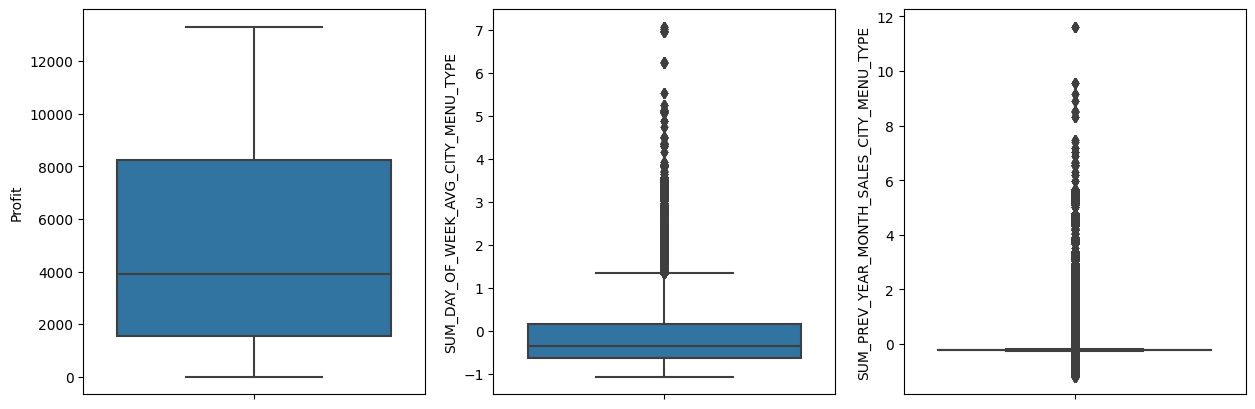

In [372]:
#check for outliers
fig, axs = plt.subplots(figsize=(15, 5), ncols=3)

sns.boxplot(y='Profit', data=X_final_scaled, ax=axs[0])
sns.boxplot(y='SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE', data=X_final_scaled, ax=axs[1])
sns.boxplot(y='SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE', data=X_final_scaled, ax=axs[2])

## Train Test Split

In [373]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

# Split the dataset into features (X) and target (y)
X = X_final_scaled.drop("Profit",axis=1)
y = X_final_scaled["Profit"]

# Split the dataset into training and testing datasets
X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_training, y_training, test_size=0.2, random_state=42)

LightGBM

In [336]:
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor()
lgbm.fit(X_train, y_train)

print('Train MSE is: ', mean_squared_error(lgbm.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(lgbm.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(lgbm.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(lgbm.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(lgbm.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(lgbm.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(lgbm.predict(X_train), y_train))
print('Test R2 is: ', r2_score(lgbm.predict(X_test), y_test))

Train MSE is:  2023885.636160862
Test MSE is:  2045224.874378391

Train RMSE is:  1422.6333456519505
Test RMSE is:  1430.113587928732

Train MAE is:  946.343699332115
Test MAE is:  946.2123571060355

Train R2 is:  0.8892868452809964
Test R2 is:  0.8886959896079126


XGBOOST

In [337]:
from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [338]:
from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

print('Train MSE is: ', mean_squared_error(xgb.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(xgb.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(xgb.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(xgb.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(xgb.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(xgb.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(xgb.predict(X_train), y_train))
print('Test R2 is: ', r2_score(xgb.predict(X_test), y_test))

Train MSE is:  1900977.7969064126
Test MSE is:  2024851.7489593595

Train RMSE is:  1378.759513804497
Test RMSE is:  1422.972856016361

Train MAE is:  920.3543073818786
Test MAE is:  942.519100817783

Train R2 is:  0.897015311234036
Test R2 is:  0.890844141403374


In [400]:
from xgboost import XGBRegressor
xgb = XGBRegressor(objective="reg:squarederror", learning_rate=0.3, max_depth=7, colsample_bytree=0.6)
xgb.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)])

print('Train MSE is: ', mean_squared_error(xgb.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(xgb.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(xgb.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(xgb.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(xgb.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(xgb.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(xgb.predict(X_train), y_train))
print('Test R2 is: ', r2_score(xgb.predict(X_test), y_test))

c:\Users\ayrto\anaconda3\envs\snowpark_0110\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:5125.69205
[1]	validation_0-rmse:3763.79522
[2]	validation_0-rmse:2881.99175
[3]	validation_0-rmse:2356.09254
[4]	validation_0-rmse:1985.56062
[5]	validation_0-rmse:1771.40778
[6]	validation_0-rmse:1658.97082
[7]	validation_0-rmse:1600.32165
[8]	validation_0-rmse:1569.11319
[9]	validation_0-rmse:1551.85895
[10]	validation_0-rmse:1504.71194
[11]	validation_0-rmse:1479.49324
[12]	validation_0-rmse:1465.38548
[13]	validation_0-rmse:1462.90075
[14]	validation_0-rmse:1460.36933
[15]	validation_0-rmse:1454.52890
[16]	validation_0-rmse:1447.54746
[17]	validation_0-rmse:1443.72172
[18]	validation_0-rmse:1440.16707
[19]	validation_0-rmse:1438.73641
[20]	validation_0-rmse:1437.94035
[21]	validation_0-rmse:1437.35753
[22]	validation_0-rmse:1435.90874
[23]	validation_0-rmse:1434.23013
[24]	validation_0-rmse:1432.48907
[25]	validation_0-rmse:1432.04677
[26]	validation_0-rmse:1431.35496
[27]	validation_0-rmse:1430.74825
[28]	validation_0-rmse:1430.21254
[29]	validation_0-rmse:1

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the hyperparameter space to search
param_distributions = {
    'learning_rate': np.logspace(-3, 0, 100),
    'n_estimators': range(100, 1000, 100),
    'max_depth': range(1, 10),
    'num_leaves': range(10, 100),
    'min_child_samples': range(1, 20),
    'reg_alpha': np.logspace(-5, 1, 100),
    'reg_lambda': np.logspace(-5, 1, 100),
}

# Create an instance of the LightGBM regressor
lgbm = LGBMRegressor()

# Create an instance of the RandomizedSearchCV object
random_search = RandomizedSearchCV(lgbm, param_distributions, n_iter=100, cv=5, n_jobs=-1)

# Fit the model to the data
random_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding mean squared error
print('Best hyperparameters: ', random_search.best_params_)
print('MSE: ', random_search.best_score_)

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization

# Define the function to optimize
def xgb_cv(n_estimators, max_depth, learning_rate, subsample, colsample_bytree):
    estimator = XGBRegressor(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42
    )
    # Calculate cross-validation score
    scores = cross_val_score(estimator, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
    return scores.mean()

# Define the parameter bounds to search over
pbounds = {
    'n_estimators': (100, 1000),
    'max_depth': (2, 10),
    'learning_rate': (0.01, 0.1),
    'subsample': (0.5, 1),
    'colsample_bytree': (0.5, 1)
}

# Create the optimizer object and run the optimization
optimizer = BayesianOptimization(f=xgb_cv, pbounds=pbounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=25)

# Get the best hyperparameters and train the model
best_params = optimizer.max['params']
model = XGBRegressor(**best_params, random_state=42)
model.fit(X_train, y_train)

print('Train MSE is: ', mean_squared_error(model.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(model.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(model.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(model.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(model.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(model.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(model.predict(X_train), y_train))
print('Test R2 is: ', r2_score(model.predict(X_test), y_test))

RANDOM FOREST

In [341]:
from sklearn. ensemble import RandomForestRegressor

# Build Random Forest Model and Evaluate both training and testing accuracy
rf = RandomForestRegressor()
rf.fit(X_train,y_train)

print('Train MSE is: ', mean_squared_error(rf.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(rf.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(rf.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(rf.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(rf.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(rf.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(rf.predict(X_train), y_train))
print('Test R2 is: ', r2_score(rf.predict(X_test), y_test))

Train MSE is:  308511.251351777
Test MSE is:  2180047.9855692377

Train RMSE is:  555.4378915340374
Test RMSE is:  1476.4985558981214

Train MAE is:  360.886337677307
Test MAE is:  966.6809363719457

Train R2 is:  0.9839401365602465
Test R2 is:  0.8824003036095197


In [407]:
from sklearn. ensemble import RandomForestRegressor

# Build Random Forest Model and Evaluate both training and testing accuracy
rf = RandomForestRegressor(min_samples_leaf=8)
rf.fit(X_train,y_train)

print('Train MSE is: ', mean_squared_error(rf.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(rf.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(rf.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(rf.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(rf.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(rf.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(rf.predict(X_train), y_train))
print('Test R2 is: ', r2_score(rf.predict(X_test), y_test))

Train MSE is:  994560.2993626765
Test MSE is:  2129701.5261698705

Train RMSE is:  997.2764407939638
Test RMSE is:  1459.3496929008725

Train MAE is:  641.0596584808596
Test MAE is:  953.4123392937148

Train R2 is:  0.9466728757765563
Test R2 is:  0.8851861220657514


In [402]:
from sklearn. ensemble import RandomForestRegressor

# Build Random Forest Model and Evaluate both training and testing accuracy
rf_model = RandomForestRegressor()

# Train the model with early stopping
best_val_error = float("inf")
best_rf_model = None
val_errors = []
for n_estimators in range(1, 100):
    rf_model.set_params(n_estimators=n_estimators)
    rf_model.fit(X_train, y_train)
    val_error = mean_squared_error(rf_model.predict(X_test), y_test)
    val_errors.append(val_error)
    if val_error < best_val_error:
        best_val_error = val_error
        best_rf_model = rf_model
    else:
        # If validation error doesn't improve for 5 iterations, stop training
        if len(val_errors) > 5 and val_errors[-5] >= val_error:
            break


print('Train MSE is: ', mean_squared_error(best_rf_model.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(best_rf_model.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(best_rf_model.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(best_rf_model.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(best_rf_model.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(best_rf_model.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(best_rf_model.predict(X_train), y_train))
print('Test R2 is: ', r2_score(best_rf_model.predict(X_test), y_test))

Train MSE is:  391062.7210088997
Test MSE is:  2325555.407411031

Train RMSE is:  625.3500787630074
Test RMSE is:  1524.9771825870152

Train MAE is:  386.2220393243776
Test MAE is:  995.5111005450261

Train R2 is:  0.9797372793799106
Test R2 is:  0.8754394983936021


In [403]:
from sklearn. ensemble import RandomForestRegressor

# Build Random Forest Model and Evaluate both training and testing accuracy
rf = RandomForestRegressor(n_estimators=13)
rf.fit(X_train,y_train)

print('Train MSE is: ', mean_squared_error(rf.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(rf.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(rf.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(rf.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(rf.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(rf.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(rf.predict(X_train), y_train))
print('Test R2 is: ', r2_score(rf.predict(X_test), y_test))

RandomForestRegressor(n_estimators=13)

In [ ]:
from sklearn. ensemble import RandomForestRegressor

# Build Random Forest Model and Evaluate both training and testing accuracy
rf = RandomForestRegressor()
rf.fit(X_train,y_train)

print('Train MSE is: ', mean_squared_error(rf.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(rf.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(rf.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(rf.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(rf.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(rf.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(rf.predict(X_train), y_train))
print('Test R2 is: ', r2_score(rf.predict(X_test), y_test))

In [25]:
rf = RandomForestRegressor()

param_grid = {"n_estimators"      : [10,30,50, 100, 200],
              'ccp_alpha': [0.0, 0.1, 0.2],
              'criterion': ['mse', 'absolute_error'],
#             "max_features"      : ["auto", "sqrt", "log2"],
#              "min_samples_leaf" : [1, 5, 10],
#             "min_samples_split" : [2, 4, 10, 12, 16], 
#              "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90],
              'max_depth' : [5, 25, 125, 525, 1225]
             }

gs = GridSearchCV(rf, param_grid=param_grid, scoring='r2', cv= 3, n_jobs=-1, verbose = 2)
# cv: number of partitions for cross validation
# n_jobs: number of jobs to run in parallel, -1 means using all processors

gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

Fitting 3 folds for each of 150 candidates, totalling 450 fits


GRADIENT BOOSTING

In [342]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor() #learning_rate= 0.04, max_depth= 8, n_estimators= 1500, subsample= 0.9
gbr = gbr.fit(X_train, y_train)

print('Train MSE is: ', mean_squared_error(gbr.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(gbr.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(gbr.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(gbr.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(gbr.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(gbr.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(gbr.predict(X_train), y_train))
print('Test R2 is: ', r2_score(gbr.predict(X_test), y_test))

Train MSE is:  2369994.086557868
Test MSE is:  2384712.252880478

Train RMSE is:  1539.4785112361485
Test RMSE is:  1544.2513567682165

Train MAE is:  1071.1504811800528
Test MAE is:  1068.449064165602

Train R2 is:  0.8636527063078826
Test R2 is:  0.863473478031057


ADABOOST

In [340]:
from sklearn. ensemble import AdaBoostRegressor

adb=AdaBoostRegressor()
adb.fit(X_train,y_train)
print('Train MSE is: ', mean_squared_error(adb.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(adb.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(adb.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(adb.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(adb.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(adb.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(adb.predict(X_train), y_train))
print('Test R2 is: ', r2_score(adb.predict(X_test), y_test))

Train MSE is:  4305665.834740885
Test MSE is:  4321046.815950517

Train RMSE is:  2075.0098396732687
Test RMSE is:  2078.7127786085593

Train MAE is:  1627.7367207160387
Test MAE is:  1628.557424586755

Train R2 is:  0.6267735325721049
Test R2 is:  0.6269079366566082


In [24]:
def cvr2(model): #Cross Validation scores function
    results  = cross_validate(model, X_train, y_train, scoring='r2', cv=5, return_train_score = True)
    print('train_score: ', results['train_score'])
    print('test_score: ', results['test_score'], '\n')

    print('cross val training R^2 value is: ', sum(results['train_score'])/len(results['train_score']))
    print('cross val testing R^2 value is: ', sum(results['test_score'])/len(results['test_score']))

def cvrm(model): #Cross Validation scores function
    results  = cross_validate(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5, return_train_score = True)
    print('train_score: ', results['train_score'])
    print('test_score: ', results['test_score'], '\n')

    print('cross val training rmse is:', -(sum(results['train_score'])/len(results['train_score'])))
    print('cross val testing rmse is:', -(sum(results['test_score'])/len(results['test_score'])))
    
def cvm(model): #Cross Validation scores function
    results  = cross_validate(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=5, return_train_score = True)
    print('train_score: ', results['train_score'])
    print('test_score: ', results['test_score'], '\n')

    print('cross val training mae is:', (-(sum(results['train_score'])/len(results['train_score']))))
    print('cross val testing mae is:', (-(sum(results['test_score'])/len(results['test_score']))))
    
def cv(model):
    print("R^2 value: ")
    cvr2(model)
    print(" \nRmse: ")
    cvrm(model)
    print(" \nMae: ")
    cvm(model)

BEST MODEL

In [ ]:
from xgboost import XGBRegressor
xgb = XGBRegressor(objective="reg:squarederror", learning_rate=0.3, max_depth=7, colsample_bytree=0.6)
xgb.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)])

print('Train MSE is: ', mean_squared_error(xgb.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(xgb.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(xgb.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(xgb.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(xgb.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(xgb.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(xgb.predict(X_train), y_train))
print('Test R2 is: ', r2_score(xgb.predict(X_test), y_test))

HYPERPARAMETER TUNING

In [412]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

# Define the function to optimize
def xgb_cv(n_estimators, max_depth, learning_rate, subsample, colsample_bytree):
    estimator = XGBRegressor(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42
    )
    # Calculate cross-validation score
    scores = cross_val_score(estimator, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
    return scores.mean()

# Define the parameter bounds to search over
pbounds = {
    'n_estimators': (100, 1000),
    'max_depth': (2, 10),
    'learning_rate': (0.01, 0.1),
    'subsample': (0.5, 1),
    'colsample_bytree': (0.5, 1)
}

# Create the optimizer object and run the optimization
optimizer = BayesianOptimization(f=xgb_cv, pbounds=pbounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=25)

# Get the best hyperparameters and train the model
best_params = optimizer.max['params']
model = XGBRegressor(**best_params, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
print('Train MSE is: ', mean_squared_error(model.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(model.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(model.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(model.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(model.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(model.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(model.predict(X_train), y_train))
print('Test R2 is: ', r2_score(model.predict(X_test), y_test))

|   iter    |  target   | colsam... | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
| 1         | -2.06e+06 | 0.6873    | 0.09556   | 7.856     | 638.8     | 0.578     |
| 2         | -2.017e+0 | 0.578     | 0.01523   | 8.929     | 641.0     | 0.854     |
| 3         | -2.033e+0 | 0.5103    | 0.09729   | 8.66      | 291.1     | 0.5909    |
| 4         | -2.035e+0 | 0.5917    | 0.03738   | 6.198     | 488.8     | 0.6456    |
| 5         | -2.19e+06 | 0.8059    | 0.02255   | 4.337     | 429.7     | 0.728     |
| 6         | -2.023e+0 | 0.5       | 0.01      | 10.0      | 646.3     | 1.0       |
| 7         | -2.522e+0 | 0.8013    | 0.0546    | 2.034     | 646.5     | 0.7102    |
| 8         | -2.082e+0 | 0.7279    | 0.05075   | 5.679     | 297.4     | 0.5842    |
| 9         | -2.608e+0 | 0.6047    | 0.07621   | 2.193     | 288.9     | 0.5936    |
| 10        | -2.068e+0 | 0.627     | 0.01436   | 9.66

In [410]:
from xgboost import XGBRegressor 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import snowflake.connector

conn = snowflake.connector.connect(
    user=username,
    password=password,
    account=accountname,
    warehouse='COMPUTE_WH'
    #warehouse='HOL_WH',
    #database='FROSTBYTE_TASTY_BYTES',
    #schema='ANALYTICS'
)
#connection
connection_parameters = {
    "account": accountname,
    "user": username,
    "password": password,
    "role": "ACCOUNTADMIN",
    "warehouse":'COMPUTE_WH'
    #"database": "FROSTBYTE_TASTY_BYTES",
    #"warehouse": "HOL_WH"
}

#cursor = conn.cursor()
#cursor.execute("ALTER WAREHOUSE HOL_WH SET WAREHOUSE_SIZE = 'MEDIUM';")

# Close the connection
#cursor.close()
#conn.close()

session = Session.builder.configs(connection_parameters).create()
#session.use_schema("ANALYTICS")
#X_final_scaled=session.sql('Select * from "Sales_Forecast_Training_Data"').to_pandas()
#X_final_scaled = X_final_scaled.iloc[:, [1, 2, 3,4,5,6,7,8,9,10,11,12,28,29,30,31,32,33,34,35,36,37]] 

#prepare training data
local_training_data = X_final_scaled
feature_cols = X_final_scaled.columns.tolist()
feature_cols.remove('Profit')
target_col = 'Profit'

X = local_training_data[feature_cols]
y = local_training_data[target_col]

# Split the dataset into training and testing datasets
X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_training, y_training, test_size=0.2, random_state=42)

#gridsearch function
def sproc_train_rf_model(session: Session) -> str:

    from xgboost import XGBRegressor
    from sklearn.metrics import mean_squared_error
    from bayes_opt import BayesianOptimization

    # Define the function to optimize
    def xgb_cv(n_estimators, max_depth, learning_rate, subsample, colsample_bytree):
        estimator = XGBRegressor(
            n_estimators=int(n_estimators),
            max_depth=int(max_depth),
            learning_rate=learning_rate,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            random_state=42
        )
        # Calculate cross-validation score
        scores = cross_val_score(estimator, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
        return scores.mean()

    # Define the parameter bounds to search over
    pbounds = {
        'n_estimators': (100, 1000),
        'max_depth': (2, 10),
        'learning_rate': (0.01, 0.1),
        'subsample': (0.5, 1),
        'colsample_bytree': (0.5, 1)
    }

    # Create the optimizer object and run the optimization
    optimizer = BayesianOptimization(f=xgb_cv, pbounds=pbounds, random_state=42)
    optimizer.maximize(init_points=5, n_iter=25)

    # Get the best hyperparameters and train the model
    best_params = optimizer.max['params']
    model = XGBRegressor(**best_params, random_state=42)
    model.fit(X_train, y_train)
        

    return "best_params: ", best_params
    #return " Results from Grid Search \n The best estimator across ALL searched params:{}\n\n The best score across ALL searched params:{}\n\n The best parameters across ALL searched params:{}\n".format(grid_xgb.best_estimator_, grid_xgb.best_score_, grid_xgb.best_params_) 


#pip install xgboost==1.7.3 first
proc_train_rf_model = session.sproc.register(func=sproc_train_rf_model, 
                                                    name='sproc_train_rf_model', 
                                                    is_permanent=True, 
                                                    replace=True, 
                                                    stage_location='@ML_MODELS', 
                                                    packages=['snowflake-snowpark-python','scikit-learn','xgboost==1.7.3','joblib', 'numpy', 'lightgbm'])


session.call('ANALYTICS.sproc_train_rf_model')

Failed to execute query [queryID: 01ac9572-3200-bf09-0000-0004730e700d] ls '@ML_MODELS'
090105 (22000): Cannot perform STAGE LS. This session does not have a current database. Call 'USE DATABASE', or use a qualified name.


SnowparkSQLException: (1304): 090105 (22000): Cannot perform STAGE LS. This session does not have a current database. Call 'USE DATABASE', or use a qualified name.

In [367]:
from xgboost import XGBRegressor 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import snowflake.connector

conn = snowflake.connector.connect(
    user=username,
    password=password,
    account=accountname,
    warehouse='COMPUTE_WH'
    #warehouse='HOL_WH',
    #database='FROSTBYTE_TASTY_BYTES',
    #schema='ANALYTICS'
)
#connection
connection_parameters = {
    "account": accountname,
    "user": username,
    "password": password,
    "role": "ACCOUNTADMIN",
    "warehouse":'COMPUTE_WH'
    #"database": "FROSTBYTE_TASTY_BYTES",
    #"warehouse": "HOL_WH"
}

cursor = conn.cursor()
cursor.execute("ALTER WAREHOUSE COMPUTE_WH SET WAREHOUSE_SIZE = 'MEDIUM';")

# Close the connection
cursor.close()
conn.close()

session = Session.builder.configs(connection_parameters).create()
#session.use_schema("ANALYTICS")
#X_final_scaled=session.sql('Select * from "Sales_Forecast_Training_Data"').to_pandas()
#X_final_scaled = X_final_scaled.iloc[:, [1, 2, 3,4,5,6,7,8,9,10,11,12,28,29,30,31,32,33,34,35,36,37]] 

#prepare training data
local_training_data = X_final_scaled
feature_cols = X_final_scaled.columns.tolist()
feature_cols.remove('Profit')
target_col = 'Profit'

X = local_training_data[feature_cols]
y = local_training_data[target_col]

# Split the dataset into training and testing datasets
X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_training, y_training, test_size=0.2, random_state=42)

#gridsearch function
def sproc_train_rf_model(session: Session) -> str:

    from xgboost import XGBRegressor
    from sklearn.model_selection import RandomizedSearchCV
    from scipy.stats import uniform, randint

    # Define hyperparameter space
    param_dist = {
        'learning_rate': uniform(0.01, 0.3),
        'max_depth': randint(1, 50),
        'min_child_weight': randint(1, 10),
        'subsample': uniform(0.1, 0.9),
        'colsample_bytree': uniform(0.1, 0.9),
        'gamma': uniform(0, 10),
        'n_estimators': randint(50, 500)
    }

    # Create XGBoost model
    xgb = XGBRegressor()

    # Create Random Search object
    rs = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=100, cv=5, random_state=42)

    # Fit the model
    rs.fit(X_train, y_train)

    # Get best hyperparameters
    best_params = rs.best_params_
    best_params = rs.bes
    

    return "best_params: {} \t best_score: {}".format(best_params, best_score_)
    #return " Results from Grid Search \n The best estimator across ALL searched params:{}\n\n The best score across ALL searched params:{}\n\n The best parameters across ALL searched params:{}\n".format(grid_xgb.best_estimator_, grid_xgb.best_score_, grid_xgb.best_params_) 


#pip install xgboost==1.7.3 first
proc_train_rf_model = session.sproc.register(func=sproc_train_rf_model, 
                                                    name='sproc_train_rf_model', 
                                                    is_permanent=True, 
                                                    replace=True, 
                                                    stage_location='@ML_MODELS', 
                                                    packages=['snowflake-snowpark-python','scikit-learn','xgboost==1.7.3','joblib', 'numpy', 'lightgbm'])


session.call('ANALYTICS.sproc_train_rf_model')

Failed to execute query [queryID: 01ac952b-3200-bf02-0000-0004730e3019] ls '@ML_MODELS'
090105 (22000): Cannot perform STAGE LS. This session does not have a current database. Call 'USE DATABASE', or use a qualified name.


SnowparkSQLException: (1304): 090105 (22000): Cannot perform STAGE LS. This session does not have a current database. Call 'USE DATABASE', or use a qualified name.

In [ ]:
from xgboost import XGBRegressor 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import snowflake.connector

conn = snowflake.connector.connect(
    user=username,
    password=password,
    account=accountname,
    warehouse='HOL_WH',
    database='FROSTBYTE_TASTY_BYTES',
    schema='ANALYTICS'
)
#connection
connection_parameters = {
    "account": accountname,
    "user": username,
    "password": password,
    "role": "ACCOUNTADMIN",
    "database": "FROSTBYTE_TASTY_BYTES",
    "warehouse": "HOL_WH"
}

cursor = conn.cursor()
cursor.execute("ALTER WAREHOUSE HOL_WH SET WAREHOUSE_SIZE = 'SMALL';")

# Close the connection
cursor.close()
conn.close()

session = Session.builder.configs(connection_parameters).create()
session.use_schema("ANALYTICS")
X_final_scaled=session.sql('Select * from "Sales_Forecast_Training_Data"').to_pandas()
X_final_scaled = X_final_scaled.iloc[:, [1, 2, 3,4,5,6,7,8,9,10,11,12,28,29,30,31,32,33,34,35,36,37]] 

#prepare training data
local_training_data = X_final_scaled
feature_cols = X_final_scaled.columns.tolist()
feature_cols.remove('Profit')
target_col = 'Profit'

X = local_training_data[feature_cols]
y = local_training_data[target_col]

# Split the dataset into training and testing datasets
X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_training, y_training, test_size=0.2, random_state=42)

#gridsearch function
def sproc_train_rf_model(session: Session) -> str:

    from xgboost import XGBRegressor 
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import RandomizedSearchCV
    from lightgbm import LGBMRegressor
    import numpy as np
    from sklearn.ensemble import RandomForestRegressor

    # gridsearch
    '''
    xgb = XGBRegressor()

    param_grid = {'learning_rate': [0.01,0.05,0.1,0.15,0.2],
                  'subsample'    : [0.6, 0.8, 1.0],
                  'n_estimators' : [100,200,300,400],
                  'max_depth'    : [4,6,8,10,12,14]
                 }

    grid_xgb = GridSearchCV(estimator=xgb, param_grid = param_grid, cv = 2, n_jobs=-1)
    grid_xgb.fit(X_train, y_train)'''


    rf = RandomForestRegressor()

    param_grid = {"n_estimators"  : [200, 300, 500, 1000],
    #            'ccp_alpha': [0.0, 0.1, 0.2],
                'criterion': ['mse', 'absolute_error'],
    #           "max_features"      : ["auto", "sqrt", "log2"],
                "min_samples_leaf" : [1, 5, 10],
                "min_samples_split" : [2, 4, 10, 12, 16], 
                "max_leaf_nodes":[None,10,30,60,90,110],
                'max_depth' : [25, 125, 525, 1225]
                 }

    gs = GridSearchCV(rf, param_grid=param_grid, scoring='r2', cv= 3, n_jobs=-1, verbose = 2)
    # cv: number of partitions for cross validation
    # n_jobs: number of jobs to run in parallel, -1 means using all processors

    gs = gs.fit(X_train, y_train)
    


    #return " Results from Grid Search \n The best estimator across ALL searched params:{}\n\n The best score across ALL searched params:{}\n\n The best parameters across ALL searched params:{}\n".format(grid_xgb.best_estimator_, grid_xgb.best_score_, grid_xgb.best_params_) 
    return   'Best hyperparameters: {}\t MSE: {}'.format(gs.best_params_,gs.best_score_)


#pip install xgboost==1.7.3 first
proc_train_rf_model = session.sproc.register(func=sproc_train_rf_model, 
                                                    name='sproc_train_rf_model', 
                                                    is_permanent=True, 
                                                    replace=True, 
                                                    stage_location='@ML_MODELS', 
                                                    packages=['snowflake-snowpark-python','scikit-learn','xgboost==1.7.3','joblib', 'numpy', 'lightgbm', 'sklearn.ensemble'])


session.call('ANALYTICS.sproc_train_rf_model')